In [67]:
import folium 
import pandas as pd
import geopandas as gpd 
from shapely.geometry import Point

In [68]:
# 道路情報から必要のないものをフィルタリングするためのリスト
FLTER_ROAD_MASK = {
    "trunk_link",
    "tertiary",
    "motorway",
    "motorway_link",
    "steps",
    None,
    " ",
    "pedestrian",
    "primary",
    "primary_link",
    "footway",
    "tertiary_link",
    "trunk",
    "secondary",
    "secondary_link",
    "tertiary_link",
    "bridleway",
    "service",
    "footway",
    "unknown"
}

# ポイントを生成する間隔（メートル）
MINI_DIST = 200

/tmp/ipykernel_52474/1734776232.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shunan_polygon = shunan_exclude_mountain.unary_union


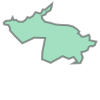

In [69]:
# # 関東のポリゴンを取得
# yamaguchi_polygon = gpd.read_file("/workspace/app/Green-View-Index/tokuyama/yamaguchi-area/N03-19_35_190101.shp")
# # 渋谷区のポリゴンを抽出
# shunan_polygon = yamaguchi_polygon[yamaguchi_polygon["N03_007"] == "35215"]
# # ポリゴンを結合
# shunan_polygon = shunan_polygon.unary_union

# 周南市のgeojsonを取得
shunan_exclude_mountain = gpd.read_file("/workspace/app/Green-View-Index/tokuyama/shunan.geojson")

#ポリゴンに変換
shunan_polygon = shunan_exclude_mountain.unary_union

shunan_polygon

In [70]:
# 道路情報の取得
roads = gpd.read_file("/workspace/app/Green-View-Index/tokuyama/chugoku-latest-free.shp/gis_osm_roads_free_1.shp")

In [71]:
# 不要な道路を除外する
roads_filtered = roads[~roads["fclass"].isin(FLTER_ROAD_MASK)]

In [72]:
# ポリゴン内の道路のみを抽出
roads_filtered = roads_filtered[roads_filtered.within(shunan_polygon)]

In [73]:
# 座標系が緯度経度WGS84 (EPSG:4326)の場合、Webメルカトル（メートル）EPSG:3857に変換
if roads_filtered.crs != "EPSG:3857":
    roads_filtered = roads_filtered.to_crs(epsg=3857)

In [74]:
from shapely.geometry import Point

# mini_dist: 点を生成する間隔（メートル）
mini_dist = MINI_DIST # 20メートルごとに点を生成

# 生成した点を格納するためのリスト
points = []

# フィルタリングされた道路データ（EPSG:3857で既に変換済み）を使用
for line in roads_filtered.geometry:
    # ラインストリングが存在し、長さがあるか確認
    if line and line.length > 0:
        # ラインストリングの長さを取得（メートル単位）
        line_length = line.length

        # 指定された距離ごとに点を生成
        for distance in range(0, int(line_length), mini_dist):
            point = line.interpolate(distance)  # 指定されたメートル単位の位置に点を生成
            points.append(point)

# 生成されたポイントを確認
print(f"生成されたポイント数: {len(points)}")
print(points[:5])

生成されたポイント数: 5127
[<POINT (14674454.129 4034017.031)>, <POINT (14674320.729 4034164.312)>, <POINT (14674443.843 4033996.733)>, <POINT (14674696.85 4033942.085)>, <POINT (14674651.231 4033944.208)>]


In [75]:
import geopandas as gpd

# 既存のGeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=points, crs="EPSG:3857")
gdf_points_wgs84 = gdf_points.to_crs(epsg=4326)

# 一意のIDを持つ新しい列を追加
gdf_points_wgs84['point_id'] = range(1, len(gdf_points_wgs84) + 1)

# WGS84座標系でのポイントとIDを確認
print(gdf_points_wgs84.head())


                     geometry  point_id
0  POINT (131.82286 34.03883)         1
1  POINT (131.82167 34.03993)         2
2  POINT (131.82277 34.03868)         3
3  POINT (131.82504 34.03827)         4
4  POINT (131.82463 34.03829)         5


In [80]:
center_lat = shunan_polygon.centroid.y
center_lon = shunan_polygon.centroid.x
# 地図の作成
map = folium.Map(location=[center_lat, center_lon], zoom_start=14, control_scale=True, tiles="cartodbdark_matter")


# GeoDataFrameの geometry 列を反復処理してポイントを追加
for point in gdf_points_wgs84.geometry:
    folium.CircleMarker(
        location=[point.y,point.x],  # 緯度（y）、経度（x）
        radius=1,
        color="red",
        fill=True,
        fill_color="red",
    ).add_to(map)

# 地図を表示
map

In [77]:
gdf_points_wgs84.to_file(f"/workspace/app/Green-View-Index/tokuyama/points_tokuyama/tokuyama_points_{MINI_DIST}.shp")